# **NLP-Based Analysis of YouTube Comments on Trump’s Global Tariffs**

## **Problem Statement**

<p style="font-size:20px; line-height:1.5; padding:10px;">
The goal of this project is to collect and analyze public reactions to the BBC News video “Donald Trump’s Global Tariffs Take Effect” by leveraging Natural Language Processing (NLP) techniques. Specifically, this project aims to:
</p>

- **Collect YouTube comments programmatically using the YouTube API.**
- **Automate data ingestion with Apache Airflow and store the collected comments in a PostgreSQL database for efficient querying and management.**
- **Perform comprehensive analysis on the comments, including sentiment analysis, topic modeling, and keyword frequency extraction, to gain insights into public opinion regarding Trump’s tariff policies.**

## **Load Dataset (PostgreSQL connection)**

<p style="font-size:20px; line-height:1.5; padding:10px;">
In the earlier stage, we used Apache Airflow and the YouTube API to store data in SQL. Here, we only need to establish a connection to a PostgreSQL database and extract data from it.
</p>

In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine

# Set PostgreSQL connection parameters
postgres_config = {
    "dbname": "postgres",
    "user": "postgres",
    "password": "Ff129962932#",
    "host": "localhost",
    "port": "5432"
}

# Create a connection engine
engine = create_engine(
    f"postgresql+psycopg2://{postgres_config['user']}:{postgres_config['password']}@{postgres_config['host']}:{postgres_config['port']}/{postgres_config['dbname']}"
)

df = pd.read_sql("SELECT * FROM youtube_comments", engine)
df


,id,video_id,author,comment,created_at
0,1,6ZFKHzKyfO4,@melissafalconbridge7490,The strangest part is that the early Americans...,2025-08-23 15:46:59.809683
1,2,6ZFKHzKyfO4,@AllahAloneWaheedah,"“Your proud nation will stumble and fall, and ...",2025-08-23 15:46:59.810685
2,3,6ZFKHzKyfO4,@AllahAloneWaheedah,“Do not let seeds be planted in that country n...,2025-08-23 15:46:59.812188
3,4,6ZFKHzKyfO4,@smash_27,ice has to work harder. after the 18th century...,2025-08-23 15:46:59.812188
4,5,6ZFKHzKyfO4,@smash_27,just trust *him*. don't think negative. he wil...,2025-08-23 15:46:59.812188
...,...,...,...,...,...
986,987,6ZFKHzKyfO4,@ConradNeill,​@@John_Smith_86 “our mutual comments have dem...,2025-08-23 15:53:47.479789
987,988,6ZFKHzKyfO4,@John_Smith_86,"@@ConradNeill Well, which of us comes off as e...",2025-08-23 15:53:47.481799
988,989,6ZFKHzKyfO4,@ConradNeill,​@@John_Smith_86 If you're trying to sound hum...,2025-08-23 15:53:47.481799
989,990,6ZFKHzKyfO4,@John_Smith_86,@@ConradNeill That is precisely what I am **no...,2025-08-23 15:53:47.482805


## **Data Preprocessing**

<p style="font-size:20px; line-height:1.5; padding:10px;">
This step is part of data preprocessing, where the raw comments are cleaned and normalized to prepare them for subsequent NLP analysis
</p>

- **Keep only alphabetic tokens – remove punctuation, numbers, emojis, and other non-alphabetic characters.**
- **Lemmatization – reduce words to their base forms (e.g., running → run).**
- **Convert to lowercase.**
- **Remove stopwords – eliminate common words (e.g., the, is, at) that do not contribute meaningful information.**
- **Reconstruct cleaned text – join the remaining tokens into a normalized sentence string.**

In [2]:
import spacy
from tqdm import tqdm

# Load spaCy English model (disable parser/ner to improve speed)
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

# Define preprocessing for a single document
def normalize_single_review(doc, lowercase=True, remove_stopwords=True):
    lemmatized = []
    for token in doc:
        if token.is_alpha:  # Keep only alphabetic tokens, remove punctuation, numbers, and special characters
            lemma = token.lemma_.lower() if lowercase else token.lemma_
            if not remove_stopwords or (remove_stopwords and not token.is_stop):
                lemmatized.append(lemma)
    return " ".join(lemmatized)

# Process the DataFrame in chunks
def process_in_chunks(df, chunk_size=1000, batch_size=500, lowercase=True, remove_stopwords=True):
    results = []

    for i in tqdm(range(0, len(df), chunk_size)):  # Loop through the dataset in chunks
        chunk = df['comment'].iloc[i:i+chunk_size].tolist()

        processed_chunk = []
        for doc in nlp.pipe(chunk, batch_size=batch_size, n_process=1):  
            processed_chunk.append(
                normalize_single_review(doc, lowercase=lowercase, remove_stopwords=remove_stopwords)
            )

        results.extend(processed_chunk)

    return results

processed_texts = process_in_chunks(df)


C:\Users\hankc\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
100%|██████████| 1/1 [00:09<00:00,  9.81s/it]


## **Top 20 Most Frequently Occurring Words**

In [3]:
from collections import Counter

all_words = []
for text in processed_texts:
    all_words.extend(text.split())

word_counts = Counter(all_words)

most_common_words = word_counts.most_common(20)
for word, count in most_common_words:
    print(word, count)


tariff 233
trump 223
pay 149
country 135
good 121
america 119
people 103
american 97
usa 91
price 80
india 75
cost 75
like 74
product 70
think 69
world 66
consumer 64
high 61
work 56
company 56


## **Key Insights**

- The **top 20 most frequent words** reveal that discussions are dominated by **trade and tariff issues**, with particular emphasis on the role of the **U.S.** and other countries such as **India**.  

- **Economic concerns** such as **prices**, **costs**, and consumer impact are frequently mentioned, highlighting public attention to the consequences of tariff policies.  


## **Perform Sentiment Analysis on a dataset of text comments**

sentiment
positive    467
negative    331
neutral     193
Name: count, dtype: int64


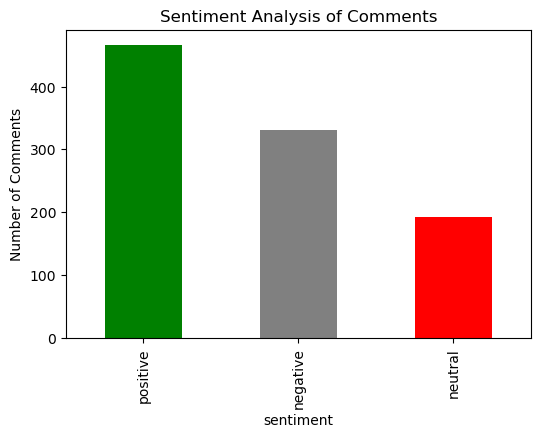

In [4]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

analyzer = SentimentIntensityAnalyzer()

def get_sentiment_label(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['comment'].apply(get_sentiment_label)
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

plt.figure(figsize=(6,4))
sentiment_counts.plot(kind='bar', color=['green','gray','red'])
plt.title('Sentiment Analysis of Comments')
plt.ylabel('Number of Comments')
plt.show()


## **Visualize common words using Word Clouds**

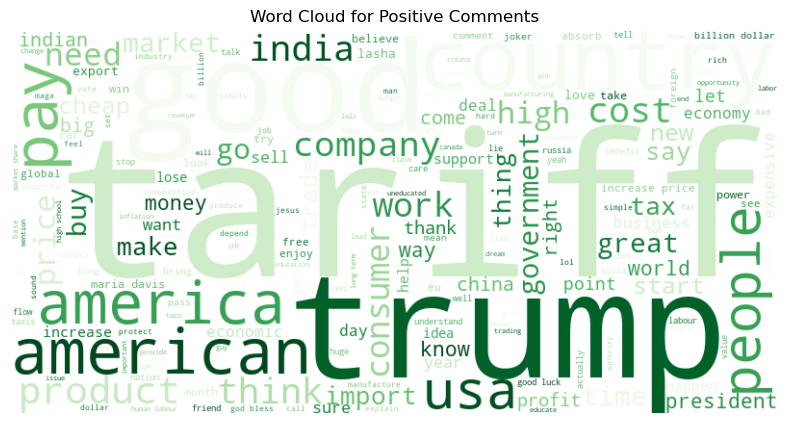

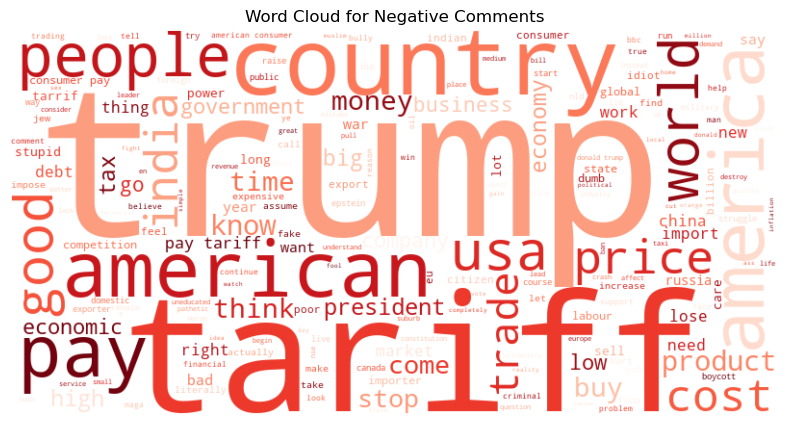

In [5]:
from wordcloud import WordCloud, STOPWORDS
df['clean_comment'] = processed_texts

positive_comments = df[df["sentiment"] == "positive"]["clean_comment"]
negative_comments = df[df["sentiment"] == "negative"]["clean_comment"]

positive_text = " ".join(positive_comments)
negative_text = " ".join(negative_comments)

stopwords = set(STOPWORDS)

# positive
wordcloud_pos = WordCloud(width=800, height=400, background_color="white",
                          stopwords=stopwords, colormap="Greens").generate(positive_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Positive Comments")
plt.show()

# negative
wordcloud_neg = WordCloud(width=800, height=400, background_color="white",
                          stopwords=stopwords, colormap="Reds").generate(negative_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Negative Comments")
plt.show()


## **Frequent Words Analysis: Top 10 Nouns, Verbs, and Adjectives by Sentiment**

In [6]:
from collections import Counter
import spacy

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

def get_top_words_by_pos(texts, pos_list, top_n=10):
    """
    texts: list of strings
    pos_list: list of POS tags, e.g., ["NOUN", "VERB", "ADJ"]
    top_n: top n words to return
    """
    all_words = []
    for doc in nlp.pipe(texts, batch_size=500, n_process=1):
        for token in doc:
            if token.pos_ in pos_list and token.is_alpha:
                all_words.append(token.lemma_.lower())
    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)

positive_texts = df[df['sentiment'] == 'positive']['clean_comment'].tolist()
negative_texts = df[df['sentiment'] == 'negative']['clean_comment'].tolist()

pos_nouns = get_top_words_by_pos(positive_texts, ["NOUN"])
pos_verbs = get_top_words_by_pos(positive_texts, ["VERB"])
pos_adjs  = get_top_words_by_pos(positive_texts, ["ADJ"])

neg_nouns = get_top_words_by_pos(negative_texts, ["NOUN"])
neg_verbs = get_top_words_by_pos(negative_texts, ["VERB"])
neg_adjs  = get_top_words_by_pos(negative_texts, ["ADJ"])

data = {
    "Positive Nouns": [word for word, _ in pos_nouns],
    "Positive Verbs": [word for word, _ in pos_verbs],
    "Positive Adjectives": [word for word, _ in pos_adjs],
    "Negative Nouns": [word for word, _ in neg_nouns],
    "Negative Verbs": [word for word, _ in neg_verbs],
    "Negative Adjectives": [word for word, _ in neg_adjs]
}

counts = {
    "Positive Nouns": [count for _, count in pos_nouns],
    "Positive Verbs": [count for _, count in pos_verbs],
    "Positive Adjectives": [count for _, count in pos_adjs],
    "Negative Nouns": [count for _, count in neg_nouns],
    "Negative Verbs": [count for _, count in neg_verbs],
    "Negative Adjectives": [count for _, count in neg_adjs]
}

df_words = pd.DataFrame({
    "Positive Nouns": [f"{w} ({c})" for w, c in zip(data["Positive Nouns"], counts["Positive Nouns"])],
    "Positive Verbs": [f"{w} ({c})" for w, c in zip(data["Positive Verbs"], counts["Positive Verbs"])],
    "Positive Adjectives": [f"{w} ({c})" for w, c in zip(data["Positive Adjectives"], counts["Positive Adjectives"])],
    "Negative Nouns": [f"{w} ({c})" for w, c in zip(data["Negative Nouns"], counts["Negative Nouns"])],
    "Negative Verbs": [f"{w} ({c})" for w, c in zip(data["Negative Verbs"], counts["Negative Verbs"])],
    "Negative Adjectives": [f"{w} ({c})" for w, c in zip(data["Negative Adjectives"], counts["Negative Adjectives"])],
})

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 150)
print(df_words)

  Positive Nouns Positive Verbs Positive Adjectives Negative Nouns Negative Verbs Negative Adjectives
0   tariff (118)       pay (43)           good (74)    tariff (85)       pay (47)           good (35)
1     trump (61)     think (35)           high (34)     trump (68)     think (21)       american (25)
2   country (58)      need (25)       economic (22)   country (57)      come (19)            low (21)
3   product (45)       say (23)          great (20)    people (46)      know (17)       economic (19)
4    people (42)      make (23)          cheap (20)       pay (32)       buy (17)           high (19)
5     price (38)        go (22)            big (19)     price (31)     trump (16)            big (18)
6    market (34)      come (20)       american (14)      cost (29)        go (14)            bad (14)
7  consumer (32)       get (20)      expensive (14)     world (28)       say (14)          right (12)
8      cost (31)       buy (20)           free (10)  consumer (27)      lose (14) 

## **Key Insights**

The analysis of positive and negative nouns, verbs, and adjectives shows that the same key topics (e.g., **tariff, Trump, country, price, product**) are discussed both positively and negatively, indicating divided opinions.  

- **Economic impact** is central: positive words stress benefits (*good, cheap, free*), while negatives highlight burdens (*high, expensive, cost*).  
- **People and countries** appear frequently, reflecting focus on who gains or loses.  
- **Negative comments** tend to use stronger emotional language (*stupid, dumb, bad*), suggesting criticism is expressed more intensely.  


## **Perform LDA topic modeling**

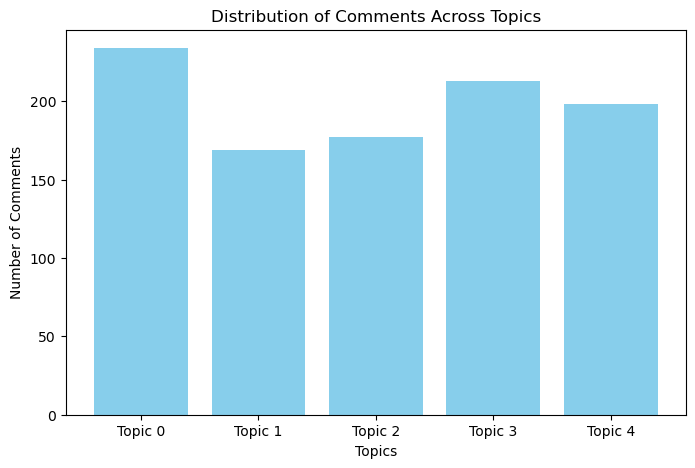



Topic 0:
['trump', 'like', 'world', 'tariff', 'america', 'day', 'great', 'country', 'india', 'epstein']

Topic 1:
['people', 'economic', 'power', 'americans', 'say', 'time', 'price', 'billion', 'america', 'dollar']

Topic 2:
['good', 'tariff', 'india', 'country', 'price', 'high', 'american', 'consumer', 'trump', 'like']

Topic 3:
['tariff', 'usa', 'pay', 'cost', 'country', 'company', 'think', 'work', 'product', 'come']

Topic 4:
['trump', 'america', 'people', 'tax', 'tariff', 'pay', 'president', 'big', 'world', 'china']



In [7]:
from sklearn.feature_extraction.text import CountVectorizer

# processed_texts 是 list of strings
vectorizer = CountVectorizer(max_df=0.95, min_df=5, stop_words='english')
X = vectorizer.fit_transform(processed_texts)  

from sklearn.decomposition import LatentDirichletAllocation

n_topics = 5 
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X)


topic_distributions = lda.transform(X)  
df["dominant_topic"] = topic_distributions.argmax(axis=1)  

topic_counts = df["dominant_topic"].value_counts().sort_index()

plt.figure(figsize=(8,5))
plt.bar(range(len(topic_counts)), topic_counts.values, color='skyblue')
plt.xticks(range(len(topic_counts)), [f"Topic {i}" for i in range(len(topic_counts))])
plt.xlabel("Topics")
plt.ylabel("Number of Comments")
plt.title("Distribution of Comments Across Topics")
plt.show()
print("\n")

# Define a function to print the top keywords for each topic
def print_topics(model, vectorizer, top_n=10):
    words = vectorizer.get_feature_names_out()  
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx}:")
        print([words[i] for i in topic.argsort()[-top_n:][::-1]])
        print()

# Print the top 10 keywords for each topic
print_topics(lda, vectorizer, top_n=10)


## **Key Insights**

LDA results show that **Topic 0** is the most discussed, characterized by keywords such as *trump, world, tariff, america, india*. This indicates that discussions are largely centered on **Trump’s policies and their global implications**, with international aspects (e.g., India) and specific events also being mentioned.  

Other topics highlight:  
- **Economic impact on people** (Topic 1)  
- **Price and consumer effects** (Topic 2)  
- **Business and cost concerns** (Topic 3)  
- **Taxation, presidency, and U.S.–China relations** (Topic 4)  


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\hankc\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\hankc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hankc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\hankc\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\hankc\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\hankc\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is alr

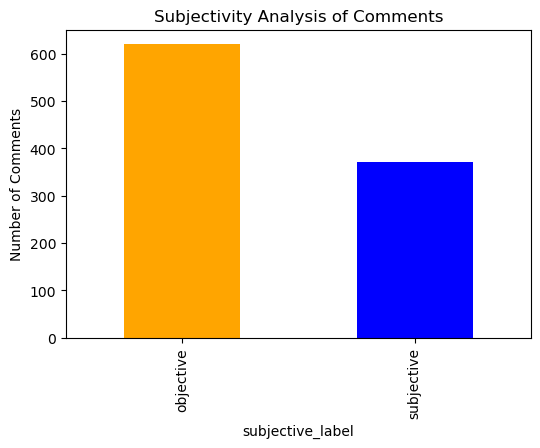

In [8]:
from textblob import TextBlob
from textblob import download_corpora

# Download TextBlob resources
download_corpora.download_all()

# Define a function to get subjectivity score
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity  # 0=objective, 1=subjective

df['subjectivity'] = df['comment'].apply(get_subjectivity)

# Label based on score (threshold 0.5)
df['subjective_label'] = df['subjectivity'].apply(
    lambda x: 'subjective' if x >= 0.5 else 'objective'
)

# Count the number of comments per label
subjectivity_counts = df['subjective_label'].value_counts()

plt.figure(figsize=(6,4))
subjectivity_counts.plot(kind='bar', color=['orange','blue'])
plt.title('Subjectivity Analysis of Comments')
plt.ylabel('Number of Comments')
plt.show()
